[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/prokaj/elte-python/blob/main/12-gyakorlat.ipynb)

In [1]:
def on_colab():
    import sys
    return 'google.colab' in sys.modules


def on_vscode():
    import os
    return 'VSCODE_PID' in os.environ


# Házi feladat

## Intervallum felezés vs. Newton--Raphson

Egy pozitív egész szám négyzetgyöke alatt értsük
  azt a legnagyobb egész számot aminek a négyzete nem nagyobb az adott
  számnál. Írjuk meg az ezt számoló függvényt két algoritmus
  alkalmazásával is. Az egyik az intervallum felezés, a másik a Newton
  iteráció módosítása. Valós számokra  a Newton algoritmus a következő
  lenne:
  $$
  x_{n+1} = \frac{x_n^2+a}{2x_n}, \quad x_0=a.
  $$
  Ezt szeretnénk úgy módosítani, hogy csak egész számok műveleteit
  használjuk és véges sok lépés után eljusson a fenti értelemben
  négyzetgyökhöz.
  

  Hasonlítsuk össze a két algoritmust az elvégzett számolási lépések
  alapján! Hogyan függ a lépések száma $a$-tól?
  Mérjük meg a futási időket is! Az eredményekből készítsünk
  ábrát!

  Végül is melyik a gyorsabb módszer?


In [2]:
def newton_root(n, cond=lambda: True):
    if n<0:
        raise ValueError
    if n==0:
        return 0
    x = n
    y = n//x
    while (y < x) and cond():
        x = (x+y) >> 1
        y = n//x
    return x
    

def bisect_root(n, cond=lambda: True):
    a, b = 0, n+1
    
    while b>a+1  and cond():
        c = (a + b)//2
        if c*c>n:
            b = c 
        else:
            a = c
    return a
    

In [5]:
try:
    import ipytest
    ipytest.autoconfig()
    
except ModuleNotFoundError:
    ! pip install ipytest

In [6]:
%%ipytest

def test_root():
    for n in range(10000):
        k = newton_root(n)
        assert type(k) is int
        assert k*k <= n < (k+1)*(k+1)

        k = bisect_root(n)
        assert type(k) is int
        assert k*k <= n < (k+1)*(k+1)

    for e in range(100):
        n = 193 + 29**(e*10)
        assert bisect_root(n)==newton_root(n)

.                                                                                            [100%]
1 passed in 3.50s


Lépésszámok.

In [7]:
from functools import wraps
class Count:    
    def __init__(self):
        self.cnt = 0

    def __call__(self):
        self.cnt += 1
        return True

    def reset(self):
        self.cnt = 0

def count_steps(f):
    cnt = Count()
    @wraps(f)
    def _f(n):
        cnt.reset()
        f(n, cnt)
        return cnt.cnt
    return _f


In [8]:
import math
exponents = [math.log(37)*(e*10) for e in range(200)]
n_values = [239 + 37**(e*10) for e in range(200)]


newton_count_steps = count_steps(newton_root)
newton_steps = [newton_count_steps(n) for n in n_values]

bisect_count_steps = count_steps(bisect_root)
bisect_steps = [bisect_count_steps(n) for n in n_values]

In [9]:
import matplotlib.pyplot as plt

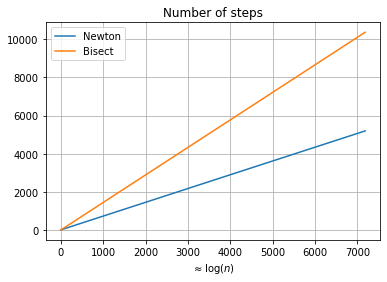

In [10]:
plt.plot(exponents, newton_steps, label="Newton")
plt.plot(exponents, bisect_steps, label="Bisect")
plt.grid()
plt.legend()
# plt.xscale('log')
plt.xlabel('$\\approx \\log(n)$')
plt.title('Number of steps')
plt.show()


Futási idők.

In [11]:
import time

def timeit(f, n, repeat=10):
    start = time.time()
    for _ in range(repeat):
        f(n)
    t = time.time()-start
    return t/repeat

import math
log2_exponents = [math.log(37)*(e*10)/math.log(2) for e in range(100)]
n_values = [239 + 37**(e*10) for e in range(100)]

newton_times = [timeit(newton_root, n) for n in n_values]
bisect_times = [timeit(bisect_root, n) for n in n_values]
    


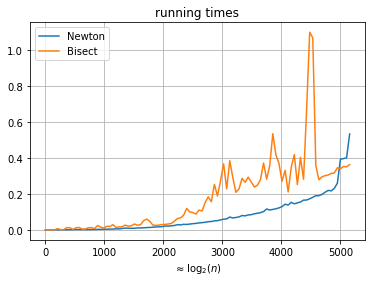

In [13]:
plt.plot(log2_exponents, newton_times, label="Newton")
plt.plot(log2_exponents, bisect_times, label="Bisect")
plt.grid()
plt.legend()
# plt.xscale('log')
plt.xlabel('$\\approx \\log_2(n)$')
plt.title('running times')
plt.show()


# Sudoku solver

Ez egy [project Euler](https://projecteuler.net/problem=96) feladat. A teszt adatok is onnan vannak:

https://projecteuler.net/project/resources/p096_sudoku.txt

In [14]:
import urllib


url = "https://projecteuler.net/project/resources/p096_sudoku.txt"

urllib.request.urlretrieve(url, "sudoku.txt")


('sudoku.txt', <http.client.HTTPMessage at 0x7f49a448a150>)

In [15]:
class Sudoku:
    
    def __init__(self, grid, name=None):
        self.grid = grid
        self.name = name

    @classmethod
    def from_file(cls, f):
        name = f.readline().strip()
        grid = [[cls.value(x) for x in f.readline().strip()] for i in range(9)]
        if any(len(line)!=9 for line in grid):
            raise ValueError
        return cls(grid, name)
    
    @staticmethod
    def value(x):
        if x=='_':
            return 0
        return int(x)

    def __str__(self):
        return f'{self.name}:\n{self.txt}'
    
    def _repr_html_(self):
        return html_table(self.grid, self.name)
    
    def copy(self):
        grid = [line.copy() for line in self.grid]
        return type(self)(grid, self.name)

    def txt(self):
        symbols='_123456789'
        grid = '\n'.join(''.join(symbols[x] for x in line) for line in self.grid)
        return grid
    
    


In [16]:
s_table_jupyter = """
<div id="{div_id}">
<style>

    div#{div_id} table#{tid}  {{
        border-collapse: collapse;
        border: 1px solid black;
    }}

    div#{div_id} table#{tid} td {{
        text-align: center;
        vertical-align: middle;
        height: 2em;
        width: 2em;
        border: 1px solid black;
    }}

    
    div#{div_id} table#{tid} tr:nth-child(3) {{
        border-bottom: 2px solid black;
    }}

    div#{div_id} table#{tid} tr:nth-child(6) {{
        border-bottom: 2px solid black;
    }}
    

    div#{div_id} table#{tid} colgroup#mid-colgroup {{
        border-left: 2px solid black;
        border-right: 2px solid black;
    }}
</style>
<table id="{tid}">
<colgroup span="3"></colgroup>
<colgroup id="mid-colgroup" span="3"></colgroup>
<caption>{name}</caption>
{table}
</table>
</div>
"""

s_table_vs = """
<div id="{div_id}">
<style>
    

    div#{div_id} table#{tid}  {{
        border-collapse: separate;
        border-spacing: 2px;
        background: #ffffff;
        width: auto;
    }}

    div#{div_id} table#{tid} td {{
        text-align: center;
        vertical-align: middle;
        color: #303030;
        background: #d0d0d0;
        height: 2em;
        width: 2em;
        display: table-cell;
    }}

    div#{div_id} tr#table-row-3,
    div#{div_id} tr#table-row-6 {{
        border-spacing: 2px;
    }}
    
</style>
<table id="{tid}">
<colgroup span="3"></colgroup>
<colgroup id="mid-colgroup" span="3"></colgroup>
<caption>{name}</caption>
<tbody>
{table}
</tbody>
</table>
</div>
"""


In [17]:
import uuid

s_table = s_table_vs if on_vscode() else s_table_jupyter

def table_cell(value):
    if value==0:
        value = ''
    return f'<td>{value}</td>'

def table_row(row, i=0):
    row = ''.join(map(table_cell, row))
    return f'<tr id="table-row-{i}">{row}</tr>'

def html_table(grid, name):
    grid = '\n'.join(table_row(line, i) for i, line in enumerate(grid, 1))
    tid = f"table-{uuid.uuid1()}"
    div_id = f"output-{uuid.uuid1()}"
    return s_table.format(div_id=div_id, tid=tid, table=grid, name=name)
    

In [18]:
with open('sudoku.txt') as f:
    sudoku = Sudoku.from_file(f)

In [19]:
sudoku

,,3,,2,,6,,
9,,,3,,5,,,1
,,1,8,,6,4,,
,,8,1,,2,9,,
7,,,,,,,,8
,,6,7,,8,2,,
,,2,6,,9,5,,
8,,,2,,3,,,9
,,5,,1,,3,,


## Mi a feladat?



A Sudokuban ki kell tölteni a hiányzó mezőket úgy, hogy minden sor, oszlop és a 9 db 3x3-as négyzet mindegyike tartalmazza az összes számot egytől kilencig.

Minden oszlop, sor és kis négyzet kilenc követelményt jelent nevezetesen azt, hogy az adott tábla részen kell, hogy legyen $1,...,9$.
Ez összesen $3*9*9$ követelmény. További követlemény, hogy minden mező pontosan egy értéket tartalmazhat. Ez további 81 követelmény, így összesen $4*9*9$
követelmény van.

Minden cellába írhatjuk a 9 szám bármelyikét ez összesen $9*9*9$ opció. 

Minden opció ki tud elégíteni néhány követelményt, pl. ha az opció az hogy (1,1) mezőben 2 van, akkor ha ezt az opciót kiválasztjuk, azzal teljesülni fog,
hogy az első sorban, első oszlopban és az (1,1) tartalmazó 3x3-as négyzetben is van 2-es.

A feladványt, akkor oldottuk meg, ha kiválasztottuk az opciók egy részét úgy, hogy minden követelményt pontosan egy opció teljesít a kiválasztottak közül. 


Kicsit messzebről ránézve, van egy páros gráfunk. A csúcsok egyik csoportja a követelményekből, a másik az opciókból áll. Egy követelmény és egy opció között akkor megy él, ha az adott opció kiválasztásával kielégítjük a követelményt.

A cél élek egy részének kiválasztása úgy, hogy minden követleményből pontosan egy él induljon ki. Ha ezt sikerült elérni, a kiválasztott élek opció végpontjai egy kitöltését adják a játékmezőnek.

A megoldás megtalálása elméletben egyszerű. 

1. Válasszunk egy `c` követelményt.
2. Válasszunk hozzá egy `r` opciót, ami `c`-t kielégíti.
3. Töröljük az összes olyan követelményt, amit `r` kielégít. 
4. Töröljük az összes olyan opciót, ami a törölt követelmények bármelyikét kielégíti kivéve `r`-et.
5. Folytassuk a kisebb gráffal, amíg el nem fogynak a követelmények.

Lehet, hogy kóddal leírva könnyebben érthető.

```
def search(G):
    req = G.first_req
    while req.neighbors:
        option = reg.neighbors.first_option
        solution = search(new_graph(G, option))
        if solution is not None:
            return (option,) + solution
        remove(G, option)
    return None
```

Itt `new_graph(G, r)` visszaadja a gráfot amit úgy kapunk, hogy 
`option` által kielégített követelményeket  és azokat az opciókat amik `option`-nal összeegyeztethetlenek elhagyjuk.

Azt feltételezzük, hogy a `new_graph` függvény nem módosítja `G`-t a visszaadott gráf másolat. 

A `remove` függvény a gráfból eltávolítja az `option` csúcsot.

A másik lehetőség, hogy a módosítást a search hívása után visszaállítjuk.

A futási idő attól függ, hogyan választjuk ki követelményt. A legegyszerűbb módszer: vegyük azt amihez aktuálisan a legkevesebb opció tartozik.
Ez pont annak felel meg, amit a játék során magunk is csinálnánk, pl ha egy mezőbe csak egy lehetőség maradt az kitöltjük. 

In [20]:
from itertools import product

def subsquare(i, j):
    return (i//3)*3 + j//3

def idx2code(n):
    n, val = divmod(n, 9)
    i, j = divmod(n, 9)
    return i, j, val

def code2idx(a, b, c):
    return a*81+b*9+c 

def satisfies(option_id, requirement_id):
    i, j, val0 = idx2code(option_id)
    t, k, val1 = idx2code(requirement_id)
    return (
        (t==3 and i==k and j==val1) or 
        (
            (val0==val1) and 
            (
                (t == 0 and i==k) or
                (t == 1 and j==k) or
                (t == 2 and subsquare(i,j) == k)
            ) 
        )
    )


class Requirement:    

    def __init__(self, idx):
        self.idx = idx
        self.neighbors = set()
    
    def __repr__(self):
        return f"{type(self).__name__}({self.idx})"

    def __str__(self):
        t, k, val = idx2code(self.idx)
        if t==3:
            return f"There must be something at ({k+1}, {val+1})"
        if t==0:
            position = f'{k+1}th row'
        elif t==1:
            position = f'{k+1}th column'
        else:
            i, j = divmod(k, 3)
            position = f'({i+1}, {j+1}) sub square'
        return f"There must be a {val+1} in the {position}"

    def is_neighbor(self, option):
        return satisfies(option, self.idx)
    
    def remove(self, to_remove):
        res = type(self)(self.idx)
        res.neighbors = self.neighbors.difference(to_remove)
        return res

    
class Option(int):
    def __str__(self):
        i, j, val = idx2code(self)
        return f"{val+1} at ({i+1}, {j+1})"


def get_options(self):
    grid = self.grid
    for i, line in enumerate(grid):
        for j, x in enumerate(line):
            if x==0:
                for val in range(9):
                    yield Option(code2idx(i, j, val))
            else:
                yield Option(code2idx(i, j, x-1))

Sudoku.options = get_options


In [21]:
options = list(sudoku.options())

In [22]:
print(*options[:20], sep=", ")

1 at (1, 1), 2 at (1, 1), 3 at (1, 1), 4 at (1, 1), 5 at (1, 1), 6 at (1, 1), 7 at (1, 1), 8 at (1, 1), 9 at (1, 1), 1 at (1, 2), 2 at (1, 2), 3 at (1, 2), 4 at (1, 2), 5 at (1, 2), 6 at (1, 2), 7 at (1, 2), 8 at (1, 2), 9 at (1, 2), 3 at (1, 3), 1 at (1, 4)


In [23]:
requirements = [Requirement(x) for x in range(4*9*9)]
len(requirements), len(options)

(324, 473)

In [24]:
o = options[10]
r = requirements[81+9]
print(f'option:\t\t\t\t{o}\nrequirement:\t\t\t{r}\noption satisfies requirement:\t{r.is_neighbor(o)}')

option:				2 at (1, 2)
requirement:			There must be a 1 in the 2th column
option satisfies requirement:	False


In [25]:
for o, r in product(options, requirements):
    if r.is_neighbor(o):
        r.neighbors.add(o)

In [26]:
requirements[0].neighbors

{0, 9, 27, 45, 63, 72}

In [27]:
min?

In [28]:
import logging
logger = logging.getLogger('sudoku')
logging.basicConfig()
logger.setLevel(logging.WARNING)


In [29]:

def search(G):
    if len(G)==0:
        return tuple()

    req = min(G, key=lambda x: len(x.neighbors))
    logger.info('%s', req)

    while len(req.neighbors)>0:

        option = next(iter(req.neighbors))
        logger.info('trying %s', option)
        
        # logger.info(f'trying {option}')
        solution = search(remove(G, option))
        
        if solution is not None:
            logger.info('%s works', option)
            return (option,) + solution
        
        logger.info('%s rejected', option)
        for r in G:
            r.neighbors.discard(option)

def remove(G, opt):
    to_remove = set.union(*(r.neighbors for r in G if opt in r.neighbors))
    to_remove.discard(opt)
    return [r.remove(to_remove) for r in G if opt not in r.neighbors]


In [30]:
# logger.setLevel(logging.DEBUG)

In [31]:
sudokus = []
with open('sudoku.txt') as f:
    while True:
        try:
            sudokus.append(Sudoku.from_file(f))
        except ValueError:
            break

In [32]:
from contextlib import contextmanager

@contextmanager
def using_level(level):
    logger = logging.getLogger('sudoku')
    _level = logger.level
    try:
        logger.setLevel(level)
        yield 
    finally:
        logger.setLevel(_level)

In [33]:
sudoku = sudokus[5]
options = list(sudoku.options())
requirements = [Requirement(x) for x in range(4*9*9)]
for o, r in product(options, requirements):
    if r.is_neighbor(o):
        r.neighbors.add(o)
display(sudoku)

with using_level(logging.CRITICAL):
    solution = search(requirements)

if solution is not None:
    sudoku_solved = sudoku.copy()
    for idx in solution:
        i, j, val = idx2code(idx)
        sudoku_solved.grid[i][j] = val+1

    display(sudoku_solved)

1,,,9,2,,,,
5,2,4,,1,,,,
,,,,,,,7,
,5,,,,8,1,,2
,,,,,,,,
4,,2,7,,,,9,
,6,,,,,,,
,,,,3,,9,4,5
,,,,7,1,,,6


1,7,6,9,2,3,5,8,4
5,2,4,8,1,7,6,3,9
8,9,3,6,5,4,2,7,1
9,5,7,3,4,8,1,6,2
6,3,8,1,9,2,4,5,7
4,1,2,7,6,5,3,9,8
2,6,5,4,8,9,7,1,3
7,8,1,2,3,6,9,4,5
3,4,9,5,7,1,8,2,6


In [34]:
def solve_sudoku(sudoku):
    options = list(sudoku.options())
    requirements = [Requirement(x) for x in range(4*9*9)]
    for o, r in product(options, requirements):
        if r.is_neighbor(o):
            r.neighbors.add(o)

    solution = search(requirements)
    return sudoku, solution

    if solution is not None:        
        sudoku = sudoku.copy()
        sudoku.name += ' solved'
        for idx in solution:
            i, j, val = idx2code(idx)
            sudoku.grid[i][j] = val+1
        
        return sudoku

def replay_solution(sudoku, solution):
    if solution is not None:        
        sudoku = sudoku.copy()
        sudoku.name += ' solved'
        for idx in solution:
            i, j, val = idx2code(idx)
            sudoku.grid[i][j] = val+1
            yield sudoku


In [35]:
len(sudokus)

50

In [36]:
if on_vscode():
    from tqdm import tqdm
else:
    from tqdm.auto import tqdm

In [37]:
solutions = [solve_sudoku(s) for s in tqdm(sudokus)]

  0%|          | 0/50 [00:00<?, ?it/s]

A fenti módszer mindig lemásolja a maradék gráfot és azon dolgozik tovább. [Knuth __Dancing Link__](https://arxiv.org/abs/cs/0011047)-nek nevezett módszerével a másolások elkerülhetőek, és valamivel gyorsabb lenne a számolás.


# MNIST

Kézzel írt számjegyek, és sok más ehhez hasonló szerkezetű adathalmaz, pl. fashionMNIST

Feladat kategorizálni a képeket az ábrázolt számjegy alapján.

In [38]:
try:
    import tensorflow_datasets as tfds
except ModuleNotFoundError:
    ! pip install  tensorflow-datasets tensorflow

In [39]:
import tensorflow as tf
import tensorflow_datasets as tfds

ds = tfds.load('mnist', split='train', shuffle_files=False)
print(len(ds))



Dl Completed...:   0%|          | 0/4 [00:00<?, ? file/s]

Dataset mnist downloaded and prepared to ~/tensorflow_datasets/mnist/3.0.1. Subsequent calls will reuse this data.
60000


In [40]:
train = ds.take(50_000).cache()
test = ds.skip(50_000).take(10_000).cache()
len(train), len(test)

(50000, 10000)

In [41]:

example = next(iter(train.batch(64).take(1).as_numpy_iterator())) 
image, label = example['image'], example['label']

(8, 8, 28, 28)


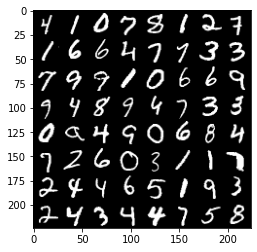

[[4 1 0 7 8 1 2 7]
 [1 6 6 4 7 7 3 3]
 [7 9 9 1 0 6 6 9]
 [9 4 8 9 4 7 3 3]
 [0 9 4 9 0 6 8 4]
 [7 2 6 0 3 1 1 7]
 [2 4 4 6 5 1 9 3]
 [2 4 3 4 4 7 5 8]]


In [42]:
import matplotlib.pyplot as plt
import numpy as np

img0 = image[:64].reshape(8,8,28,28)
print(img0.shape)
img0 = np.transpose(img0, axes=(0,2,1,3)).reshape(8*28, 8*28)
plt.imshow(img0, cmap="gray")
plt.show()
print(label[:64].reshape(8,8))

In [43]:
image.shape, label.shape

((64, 28, 28, 1), (64,))

## Feladat: Kategorizáljuk a képeket
## Hogyan lehet ilyesmit leprogramozni?

Az első ötletünk az lehet, hogy próbáljuk megérteni, mitől érzékelünk egy képet 1-esnek, 2-esnek, stb. majd ezt valahogy formalizáljuk végül lekódoljuk.

Ez teljesen reménytelennek tűnik. Ehelyett inkább olyan eljárást keresünk, ami egy könnyen számolható függvény osztályból kiválaszt egyet, ami az esetek többségében jól működik. 

#### Milyen függvény osztályok jöhetnek szóba?

A függvény bemenete egy kép, jelen esetben szürkeárnyalatos 28x28 pixeles kép. Azaz minden bemenet 28x28 intenzitás értékkel van megadva. 
Erre gondolhatunk úgy, hogy egy 784 dimenziós (valós) vektorra. 


Mi lenne a függvény kimenete? 10 lehetséges kategória (osztály) között kell választani. Ezért a kimenet lehetne egy egész 0 és 9 között, de egyszerűbb 10 értéket kiszámolni és aztán a döntés a legnagyobb érték indexe.  

Azaz keresünk egy
$$
    g:\mathbb{R}^{784} \to \mathbb{R}^{10}, \quad f = \arg\max(g)
$$

A legegyszerűbb függvények a lineáris függvények, ezek könnyen paraméterezhetőek.

Általában is függvény osztály elemeit paraméteresen adjuk meg és a paramétereket szeretnénk azonosítani. 


## Paraméterek keresése, veszteség minimalizálás

Mikor gondolnánk egyik függvényt jobbnak mint a másikat? Nyilván akkor, ha több helyest döntést hoz. Azaz $g_0(x_i),\dots,g_9(x_i)$ értékek 
közül az esetek többségében az $y_i$ indexű a legnagyobb, ahol $(x_i,y_i)$ az ismert input-output párokat jelöli.

Egy lehetséges kritérium, hogy az $y_i$ indexet 0-1 vektorként kódoljuk $z_i=(\mathbb{1}_{k=y_i})_{k=0}^9$ és olyan $g$-t keresünk, amire
$$
    \sum_i \|g(x_i) - z_i\|^2 
$$
minimális.

Egy másik lehetőség lehetne, hogy a
$$
    \sum_i \sum_k (2z_{i,k}-1)*g_k(x_i)
$$
kifejezést próbálnánk maximalizálni. Ezzel az a gond, hogy felülről nem feltétlenül korlátos.

Egy további lehetőség lehetne, hogy a
$$
    \sum_i \sum_k \max(1-(2z_{i,k}-1)*g_k(x_i),0)
$$
minimalizálása, vagy
$$
    \sum_i -\log p_{y_i}(x_i), \quad p_k(x)=\frac{e^{g_k(x)}}{\sum_\ell e^{g_\ell(x)}}
$$
minimalizálása.

Ezekben az a közös, hogy megfogalmazhatóak egy ($x$-ben differenciálható) veszteség minimalizálásaként.


## Gradiens ereszkedés (Gradient descent)
Néhány esetben a megoldás kifejezhető az $(x_i, y_i)$ párok segítségével, de még ezekben az esetekben is inkább általános iterative eljárást szoktak használni. 

A $g(x)$ valójában $g(x,\vartheta)$, ahol $\vartheta$ a függvény megadására szolgáló paraméter vektor. pl. ha $g$ lineáris, akkor
$$
    g(x) = b + Ax,\quad \vartheta=(b, A),\quad b\in\mathbb{R}^{10},\quad A\in\mathbb{R}^{10\times 784}, \quad x\in\mathbb{R}^{784}
$$

Azaz $g$ a paraméter szerint is deriválható. Ha $\ell$ jelöli a veszteség függvényt, akkor
$$
    \hat\vartheta = \arg\min_{\theta}L(\vartheta), \quad L(\vartheta) = \frac1n\sum_{i} \ell (g(x_i,\vartheta), y_i)
$$
úgy is számolható, hogy
$$
    \vartheta_{n+1} = \vartheta_n -\eta L'(\vartheta_n)
$$
ahol $\eta$ általában egy kicsi szám, a tanulási ráta. Mindig abba az irányba próbáljuk $\vartheta_n$-t módosítani amerre a leginkább csökken.
Ezt a minimalizálási eljárást gradiens ereszkedésnek hívják.

Gyakran nem kell $L'$-t pontosan számolni elegendő az adatok egy $b$ részét használni, Azaz $L'$ helyett $L'_b$-t használjuk, ahol
$$
    L'_b(\vartheta)=\frac{1}{|b|}\sum_{i\in b} \partial_\vartheta\ell(g(x_i, \vartheta), y_i)
$$

Szerencsére a derivált számolást nem kell leprogramozni. A neurális hálós keretrendszerek mind megteszik ezt nekünk. Mi a `jax` könytárat fogjuk használni.



In [53]:
try:
    import jax
except ModuleNotFoundError:
    ! pip install jax[cpu]


In [54]:
from jax import grad
import jax.numpy as jnp

def tanh(x):  # Define a function
  y = jnp.exp(-2.0 * x)
  return (1.0 - y) / (1.0 + y)

grad_tanh = grad(tanh)  # Obtain its gradient function
print(grad_tanh(1.0))   # Evaluate it at x = 1.0
# prints 0.4199743

0.4199743


In [55]:
import jax
import jax.numpy as jnp

In [56]:
def g(theta, x):
    x = x.reshape(-1)
    b, A = theta
    return b + A @ x

def f(g):
    return g.argmax()

theta = np.random.normal(size=10), np.random.normal(size=(10, 784))

In [57]:
x = image[0]
pred = g(theta, x)
print(f'{pred}\nA képen {f(pred)} van?')

[ 2698.66583828 -1146.86531828  -253.74025906  -229.91780306
 -1562.63205004 -3107.02071017   -72.33392557  -381.99090192
  1881.96942709  -468.53468736]
A képen 0 van?


Szerencsésebb lenormálni az $A$ mátrixot, és a képet is.

In [58]:
image[0].max()

255

In [59]:
def g(theta, x):
    x = x.reshape(-1)/255
    b, A = theta
    return b + A @ x

def f(g):
    return g.argmax()

theta = np.random.normal(size=10), (784**(-0.5))*np.random.normal(size=(10, 784))

[-0.41578566  0.25612633  2.11939334 -0.8039097   1.6511965  -0.88581568
  0.08352487  0.54349387 -0.80915929  0.25081738]
A képen 2 van?


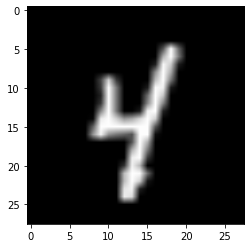

In [61]:

x = image[0]
pred = g(theta, x)
print(f'{pred}\nA képen {f(pred)} van?')
plt.imshow(x.squeeze(), cmap='gray', interpolation='bilinear')

## Veszteség függvény

Válasszuk a keresztentrópiát:
$$
    \sum_i -\log p_{y_i}(x_i)=\sum -g_{y_i}(x_i)+\log(\sum_je^{g_j(x_i)}), \quad p_k(x)=\frac{e^{g_k(x)}}{\sum_j e^{g_j(x)}}
$$

In [62]:
def ell(pred, y):
    return jax.nn.log_softmax(pred) @ y

def ell(pred, y):
    return -pred@y + jax.nn.logsumexp(pred)


In [63]:
y = jax.nn.one_hot(label[0], 10)
pred = g(theta, x)
log_p = jax.nn.log_softmax(pred)
print(f'pred: \t{pred}\none-hot:\t{y}\nlog p:\t{log_p}\nloss:\t{ell(pred, y)}')

pred: 	[-0.41578566  0.25612633  2.11939334 -0.8039097   1.6511965  -0.88581568
  0.08352487  0.54349387 -0.80915929  0.25081738]
one-hot:	[0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
log p:	[-3.4550767  -2.7831645  -0.91989744 -3.8432007  -1.3880943  -3.9251065
 -2.9557657  -2.495797   -3.8484502  -2.7884734 ]
loss:	1.388094425201416


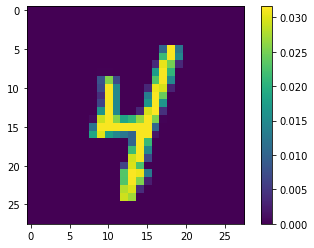

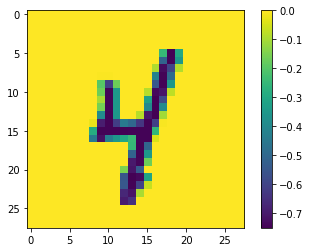

In [64]:
def L(theta, x, y):
    pred = g(theta, x)
    return ell(pred, y)

dL = grad(L)

dx, dA = dL(theta, x, y)

plt.imshow(dA[0].reshape(28,28))
plt.colorbar()
plt.show()

plt.imshow(dA[4].reshape(28,28))
plt.colorbar()
plt.show()

In [65]:
batch_L = jax.vmap(L, in_axes=None)
batch_L(theta, x=image[:16]/255, y=jax.nn.one_hot(label[:16], 10))


DeviceArray([1.4791261, 2.6170578, 3.0597365, 1.9431098, 3.7091212,
             2.6172037, 1.1082135, 1.9426873, 2.616953 , 2.9140818,
             2.9134586, 1.47857  , 1.9430153, 1.9424948, 3.8954434,
             3.8960702], dtype=float32)

In [66]:
def loss_fn(theta, x, y):
    return batch_L(theta, x=x, y=y).mean(axis=0)

loss_fn = jax.value_and_grad(loss_fn)

def training_step(theta, x, y, eta):
    y = jax.nn.one_hot(y, 10)
    loss, gradient = loss_fn(theta, x=x, y=y)
    return loss, jax.tree_map(lambda t, g: t-eta*g, theta, gradient)

In [67]:
# loss_fn(theta, x=image[:16]/255, y=jax.nn.one_hot(label[:16], 10))
loss, gradient = training_step(theta, x=image[:16], y=label[:16], eta=0.1)

In [68]:
gradient

(DeviceArray([-0.12213972,  0.33213502,  1.7969226 , -0.9487937 ,
               1.4420581 , -0.83141893,  0.02700397,  1.0108197 ,
              -0.76969695,  0.07066879], dtype=float32),
 DeviceArray([[-3.5338219e-02,  3.8177952e-02, -1.2040961e-01, ...,
               -8.3390176e-03,  1.8301590e-03, -5.4083679e-02],
              [-3.3384807e-02,  2.5854276e-02,  2.3810353e-02, ...,
                4.4284441e-02,  6.3785082e-03, -3.0625826e-02],
              [-6.0049579e-03,  1.4733897e-02, -1.4513173e-03, ...,
                4.3028440e-02,  3.4985566e-03, -1.4367308e-02],
              ...,
              [-1.2081476e-02, -6.7605644e-02,  3.3568889e-02, ...,
               -3.3601306e-03, -2.5137199e-02, -7.3738857e-03],
              [ 3.3115615e-05,  2.3221739e-02, -2.2675198e-02, ...,
               -4.0710997e-02, -2.5169304e-02, -9.1022337e-03],
              [ 7.5366862e-02,  5.1680788e-02, -2.0083640e-02, ...,
               -1.4742799e-02, -8.4927045e-03,  3.8484506e-02]],

In [69]:
theta = theta = 0.1 * np.random.normal(size=10), (784**(-0.5))*np.random.normal(size=(10, 784))
eta = 0.1
losses = []

for i, example in tqdm(enumerate(train.repeat().shuffle(10000).batch(256).take(2000).as_numpy_iterator())):
    img, label = example['image'], example['label']
    loss, theta = training_step(theta, img, label, eta)
    losses.append(loss)
    if (i+1) % 200==0:
        eta *= 0.5

0it [00:00, ?it/s]

In [70]:
eta

9.765625e-05

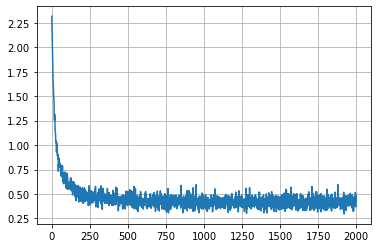

In [71]:
plt.plot(losses)
plt.grid()
plt.show()

In [72]:
def predict(theta, x):
    return jax.vmap(g, in_axes=None)(theta, x=x).argmax(axis=1)

In [73]:
from sklearn.metrics import confusion_matrix
import pandas as pd

def cm_(y_true, y_pred, classes=None):
    if classes is None:
        classes = np.unique(y_true)
    cm = pd.DataFrame(
        confusion_matrix(
            y_pred=y_pred, 
            y_true=y_true, 
            labels=classes
            ), 
            columns=classes, 
            index=classes)
    cm.index.name = 'True'
    cm.columns.name = 'Predicted'
    return cm


In [74]:
preds = []
labels = []
for example in test.batch(256).as_numpy_iterator():
    img, label = example['image'], example['label']
    preds.append(predict(theta, x=img))
    labels.append(label)
preds = np.concatenate(preds)
labels = np.concatenate(labels)
print('test tévesztési mátrix')
cm_(y_pred=preds, y_true=labels)
#confusion_matrix(y_pred=preds, y_true=label, labels=range(10))

test tévesztési mátrix


Predicted,0,1,2,3,4,5,6,7,8,9
True,,,,,,,,,,
0,910,0,6,4,1,11,9,1,16,1
1,1,1092,7,6,1,5,1,4,11,1
2,6,13,857,10,25,3,23,25,32,5
3,8,3,24,887,1,38,4,13,23,16
4,2,10,11,0,897,1,12,1,11,42
5,20,11,9,46,22,718,18,7,44,17
6,5,5,14,3,13,16,923,0,9,0
7,8,20,17,2,16,0,0,957,1,36
8,8,34,19,42,11,20,8,5,805,21


In [75]:
preds = []
labels = []
for example in train.batch(256).as_numpy_iterator():
    img, label = example['image'], example['label']
    preds.append(predict(theta, x=img))
    labels.append(label)
preds = np.concatenate(preds)
labels = np.concatenate(labels)
print('train tévesztési mátrix')
cm_(y_pred=preds, y_true=labels)


train tévesztési mátrix


Predicted,0,1,2,3,4,5,6,7,8,9
True,,,,,,,,,,
0,4757,0,24,21,12,29,52,4,58,7
1,0,5411,27,25,4,42,10,13,71,10
2,48,75,4203,89,107,12,119,103,155,48
3,29,37,134,4387,5,223,42,74,114,69
4,9,29,37,4,4365,5,62,14,47,283
5,91,70,41,218,70,3633,98,27,185,76
6,45,26,65,3,36,75,4623,4,51,2
7,40,81,86,18,75,12,4,4677,21,194
8,27,154,59,160,20,153,45,32,4124,104


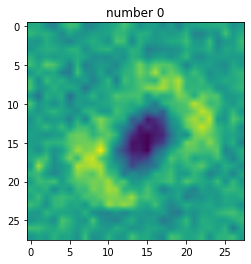

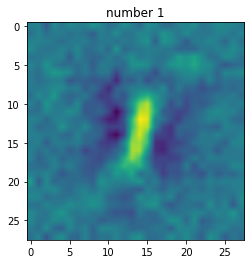

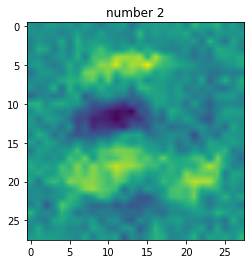

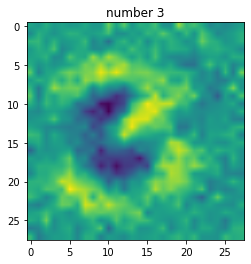

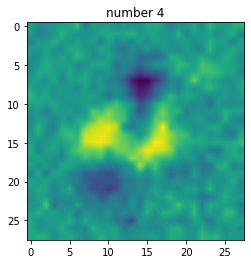

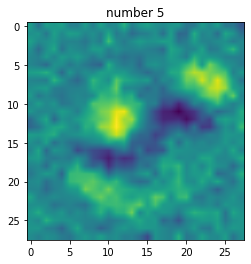

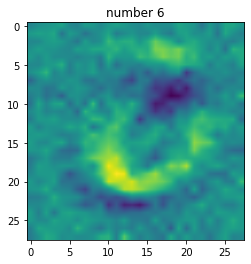

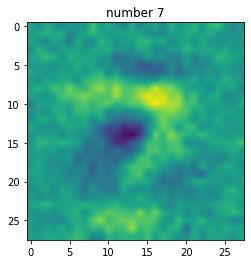

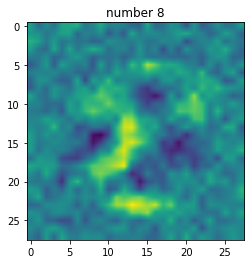

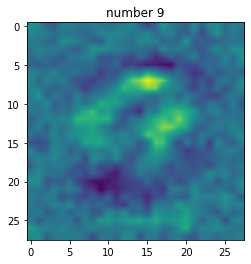

In [76]:
b, A = theta
for i, row in enumerate(A):
    plt.imshow(row.reshape(28, 28), interpolation='bilinear')
    plt.title(f'number {i}')
    plt.show()

## Több rétegű neurális háló

Lineáris függvények családja nagyon szűk. 

Az derül ki, hogy ha $g_1\circ \sigma\circ g_2$ alakban már tetszőleges (folytonos) függvény közelíthető, ha a közepső tér dimenziója elég nagy és
$\sigma$ egy koordinátánként számolt nem lineáris **aktivációs** függvény. Szokásos választások $\sigma$-ra $\sigma(x)=\max(x,0)$,  vagy $\sigma(x)=\tanh(x)$, vagy $\sigma(x)=1/(1+e^{-x})$ (mindegyik koordinátánként értendő).

A következő rész a `jax` dokumentációjában szereplő példa.

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/google/jax/blob/main/docs/notebooks/Neural_Network_and_Data_Loading.ipynb)

In [77]:
import jax.numpy as jnp
from jax import grad, jit, vmap
from jax import random

A véletlen számokat a `jax` rendszer kicsit másképp kezeli. A véletlenszám generátornak mindig meg kell adni egy kulcsot (a generátor állapotát).
Új véletlenszám generálása előtt a kulcsot szét kell bontani, az egyikből az aktuális érték(ek)et szzámoljuk, a másikból a következőket.

In [78]:
# A helper function to randomly initialize weights and biases
# for a dense neural network layer
def random_layer_params(m, n, key, scale=1e-2):
  w_key, b_key = random.split(key)
  return scale * random.normal(w_key, (n, m)), scale * random.normal(b_key, (n,))

# Initialize all layers for a fully-connected neural network with sizes "sizes"
def init_network_params(sizes, key):
  keys = random.split(key, len(sizes))
  return [random_layer_params(m, n, k) for m, n, k in zip(sizes[:-1], sizes[1:], keys)]

layer_sizes = [784, 512, 512, 10]
params = init_network_params(layer_sizes, random.PRNGKey(0))

A `predict` függvény hasonló a fentihez, de most minden (rejtett) réteg után alkalmazunk egy `relu` (rectified linear unit, igazából pozitív rész) nem linearitást, vagy aktivációs függvényt. 

In [79]:
from jax.scipy.special import logsumexp

def relu(x):
  return jnp.maximum(0, x)

def predict(params, image):
  # per-example predictions
  activations = image.flatten()/255.0
  for w, b in params[:-1]:
    outputs = jnp.dot(w, activations) + b
    activations = relu(outputs)
  
  final_w, final_b = params[-1]
  logits = jnp.dot(final_w, activations) + final_b
  return logits - logsumexp(logits)

In [80]:
# This works on single examples
preds = predict(params, image[0])
print(preds.shape)
print(preds)

(10,)
[-2.2953994 -2.2987492 -2.2974277 -2.318979  -2.3008723 -2.3090346
 -2.3071167 -2.3012722 -2.3021984 -2.2950432]


Ugyanúgy mint a lineáris esetben a `predict` függvény nem képes több képet egyszerre kezelni. 

In [81]:
try:
  preds = predict(params, image[:10])
except TypeError:
  print('Invalid shapes!')

Invalid shapes!


A `vmap` transzformáció most is segít.

In [82]:
batched_predict = vmap(predict, in_axes=(None, 0))

batched_preds = batched_predict(params, image[:8])
print(batched_preds.shape)

(8, 10)


In [83]:
n_targets = 10

In [84]:
def y_pred_true(f, params, dataset):
    y_pred = []
    y_true = []
    for example in tqdm(dataset.batch(256).as_numpy_iterator()):
        images, targets = example['image'], example['label']
        y_pred.append(f(params, images).argmax(axis=-1))
        y_true.append(targets)
    y_pred = np.concatenate(y_pred)
    y_true = np.concatenate(y_true)
    return {'y_pred': y_pred, 'y_true':y_true}

def accuracy(f, params, dataset):
    y = y_pred_true(f, params, dataset)
    acc = sum(y['y_pred'] == y['y_true'])
    n = len(y['y_pred'])
    return acc/n

def loss(params, images, targets):
    targets = jax.nn.one_hot(targets, n_targets)
    preds = batched_predict(params, images)
    return -jnp.mean(preds * targets)*n_targets

@jit
def update(params, x, y):
    grads = grad(loss)(params, x, y)
    return jax.tree_map(lambda p, g: p - step_size * g, params, grads)


Konstansok:

In [85]:
step_size = 0.1
num_epochs = 8
batch_size = 128


In [86]:
import time

for epoch in range(num_epochs):
  start_time = time.time()
  for example in tqdm(train.shuffle(5000).batch(128).as_numpy_iterator()):
    x, y = example['image'], example['label']
    params = update(params, x, y)
  epoch_time = time.time() - start_time

  train_acc = accuracy(batched_predict, params, train)
  test_acc = accuracy(batched_predict, params, test)
  print("Epoch {} in {:0.2f} sec".format(epoch, epoch_time))
  print("Training set accuracy {}".format(train_acc))
  print("Test set accuracy {}".format(test_acc))

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

Epoch 0 in 5.15 sec
Training set accuracy 0.86724
Test set accuracy 0.8683


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

Epoch 1 in 3.83 sec
Training set accuracy 0.9064
Test set accuracy 0.906


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

Epoch 2 in 4.26 sec
Training set accuracy 0.93148
Test set accuracy 0.9276


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

Epoch 3 in 3.71 sec
Training set accuracy 0.948
Test set accuracy 0.9433


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

Epoch 4 in 3.73 sec
Training set accuracy 0.95644
Test set accuracy 0.9511


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

Epoch 5 in 3.72 sec
Training set accuracy 0.9645
Test set accuracy 0.9578


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

Epoch 6 in 3.77 sec
Training set accuracy 0.96984
Test set accuracy 0.9623


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

Epoch 7 in 4.35 sec
Training set accuracy 0.97022
Test set accuracy 0.961


In [87]:
train_y = y_pred_true(batched_predict, params, train)
cm_(train_y['y_pred'], train_y['y_true'])

0it [00:00, ?it/s]

Predicted,0,1,2,3,4,5,6,7,8,9
True,,,,,,,,,,
0,4903,0,6,3,5,35,17,5,12,15
1,1,5546,5,4,17,12,7,20,46,11
2,26,27,4893,52,25,15,8,52,74,2
3,8,14,26,5017,4,152,0,9,96,63
4,1,2,7,0,4645,5,5,10,3,37
5,1,0,0,8,2,4185,2,1,7,6
6,13,4,2,0,47,53,4884,1,23,2
7,1,9,15,12,7,2,0,5074,6,46
8,7,9,3,9,7,32,7,5,4596,20


In [88]:
test_y = y_pred_true(batched_predict, params, test)
cm_(test_y['y_pred'], test_y['y_true'])

0it [00:00, ?it/s]

Predicted,0,1,2,3,4,5,6,7,8,9
True,,,,,,,,,,
0,938,1,2,0,1,13,4,2,5,5
1,0,1102,3,0,4,2,2,1,14,5
2,8,9,978,14,6,3,3,11,15,5
3,2,7,5,990,0,40,0,4,21,14
4,1,1,4,0,949,1,3,1,1,13
5,0,0,0,2,0,824,1,1,0,0
6,5,0,0,0,8,8,974,0,12,0
7,0,5,6,3,3,2,0,1031,2,10
8,2,3,1,4,2,9,1,0,899,2


## Konvolúciós háló

Az ötlet az, hogy a kép kis részeit tekintsük, pl. az összes 5*5-ös részképet és mindegyikre ugyanazt a lineáris leképezést alkalmazzuk, majd az eredményekre az aktivációs függvényt. Ezzel kapunk egy másik (gyakran kisebb) képet ahol, nem 1 vagy 3 ,,szín'' van, hanem sok, attól függően, hogy hány ismérvet számolunk ki a kis képből. Ezzel a kép lokális tulajdonságait lehet kigyűjteni (van vonal vagy nincs, annak az iránya stb). Ilyen rétegeket pakolunk egymásra és a végén a kapott képre az imént látott összegzést alkalmazzuk.
 


In [92]:
try:
    import haiku as hk
except ModuleNotFoundError:
    ! pip install dm-haiku

In [93]:
hk.MaxPool?

In [94]:
hk.transform?

In [95]:
def lenet(x):
    x = x.astype(jnp.float32)/255
    x = hk.Conv2D(32, 5, padding='VALID')(x)
    x = jax.nn.relu(x)
    x = hk.MaxPool(2, 2, padding='VALID')(x)
    #x = hk.Conv2D(64, 5, 'VALID')(x)
    x = jax.nn.relu(x)
    x = hk.MaxPool(2, 2, padding='VALID')(x)
    x = hk.Flatten()(x)
    x = hk.Linear(128)(x)
    x = jax.nn.relu(x)
    x = hk.Linear(n_targets)(x)
    x = jax.nn.log_softmax(x)
    return x


In [96]:
param_init, lenet_apply = hk.transform(lenet)
def lenet_fn(params, images):
    return lenet_apply(params, None, images)

In [97]:
key = jax.random.PRNGKey(0)
params = param_init(key, image[:10])

In [98]:
lenet_apply(params, None, image[:1])

DeviceArray([[-2.2921522, -2.4065294, -2.1999078, -2.1794224, -2.448887 ,
              -2.2928278, -2.1351295, -2.393769 , -2.602898 , -2.1719048]],            dtype=float32)

In [99]:

def lenet_loss(params, images, targets):
  targets = jax.nn.one_hot(targets, n_targets)
  preds = lenet_apply(params, None, images)
  return -jnp.mean(preds * targets)*n_targets

@jit
def lenet_update(params, x, y):
  grads = grad(lenet_loss)(params, x, y)
  return jax.tree_map(lambda p, g: p - step_size * g, params, grads)


In [100]:
import time

for epoch in range(num_epochs):
  start_time = time.time()
  for example in tqdm(ds.cache().shuffle(5000).batch(128).as_numpy_iterator()):
    x, y = example['image'], example['label']
    params = lenet_update(params, x, y)
  epoch_time = time.time() - start_time

  train_acc = accuracy(lenet_fn, params, train)
  test_acc = accuracy(lenet_fn, params, test)
  print("Epoch {} in {:0.2f} sec".format(epoch, epoch_time))
  print("Training set accuracy {}".format(train_acc))
  print("Test set accuracy {}".format(test_acc))

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

Epoch 0 in 35.23 sec
Training set accuracy 0.9613
Test set accuracy 0.9631


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

Epoch 1 in 32.94 sec
Training set accuracy 0.97604
Test set accuracy 0.9773


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

Epoch 2 in 34.57 sec
Training set accuracy 0.98134
Test set accuracy 0.9818


0it [00:00, ?it/s]

0it [00:08, ?it/s]

0it [00:00, ?it/s]

Epoch 3 in 32.60 sec
Training set accuracy 0.98574
Test set accuracy 0.9871


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

Epoch 4 in 32.83 sec
Training set accuracy 0.98806
Test set accuracy 0.9892


0it [00:00, ?it/s]

0it [00:07, ?it/s]

0it [00:00, ?it/s]

Epoch 5 in 33.11 sec
Training set accuracy 0.98828
Test set accuracy 0.9895


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

Epoch 6 in 33.08 sec
Training set accuracy 0.99006
Test set accuracy 0.9923


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

Epoch 7 in 35.16 sec
Training set accuracy 0.99098
Test set accuracy 0.9914


In [101]:
train_y = y_pred_true(lenet_fn, params, train)
cm_(train_y['y_pred'], train_y['y_true'])

0it [00:00, ?it/s]

Predicted,0,1,2,3,4,5,6,7,8,9
True,,,,,,,,,,
0,4955,1,7,9,0,4,16,3,15,10
1,0,5579,3,0,2,1,0,8,3,1
2,2,14,4927,9,0,3,1,18,14,0
3,0,0,3,5048,0,7,1,1,1,0
4,0,4,4,0,4815,1,4,9,9,6
5,1,0,0,16,0,4472,5,1,13,2
6,1,2,1,1,2,10,4900,0,10,0
7,0,8,5,6,1,0,0,5134,2,4
8,0,2,2,3,2,2,3,3,4776,4


In [102]:
test_y = y_pred_true(lenet_fn, params, test)
cm_(test_y['y_pred'], test_y['y_true'])

0it [00:00, ?it/s]

Predicted,0,1,2,3,4,5,6,7,8,9
True,,,,,,,,,,
0,956,1,0,0,1,1,2,0,2,1
1,0,1120,1,0,0,0,0,1,2,0
2,0,4,995,1,0,0,0,0,2,0
3,0,0,0,1012,0,1,0,2,2,0
4,1,1,0,0,980,0,2,1,2,0
5,0,0,0,1,0,905,2,0,3,0
6,0,0,0,0,1,1,982,0,1,0
7,0,3,1,0,0,0,0,1045,1,2
8,0,0,1,0,0,0,0,0,944,1
